In [1]:
import argparse
import os
from functools import partial
from os.path import join
from typing import Any, Dict, Optional, Union

import torch
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses.dice import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete, Compose, LoadImaged
from torch.utils.data import DataLoader

from bts.common import logutils, miscutils
from bts.common.miscutils import DotConfig
from bts.data.dataset import (
    ConvertToMultiChannelBasedOnEchidnaClassesd,
    EchidnaDataset,
    JsonTransform,
)
from bts.data.utils import UnsqueezeDatad, save_prediction_as_nrrd
from bts.swinunetr import model as smodel

import matplotlib.pyplot as plt

In [2]:
logger = logutils.get_logger(__name__)

In [3]:
def _generate_data_paths():
    """Generate data paths for image, label and info files.

    Each sample should have the following files in its directory:
        image.nrrd: Image.
        label.nrrd: Segmentation labels.
        info.json: Sample metadata.

    Returns:
        List of samples structured as a dictionary. Each sample have the following
        keys:
            img: Path to the image nrrd file.
            label: Path to the label nrrd file.
            info: Path to the metadata json file.
    """
    data_paths = []

    for folder_index in range(8):
        sample_folder_path = os.path.join("/home/vedatb/senior-project/data/btsed_dataset", str(folder_index))

        sample_data_paths = {
            "img": os.path.join(sample_folder_path, "image.nrrd"),
            "label": os.path.join(sample_folder_path, "label.nrrd"),
            #"info": os.path.join(sample_folder_path, "info.json"),
        }
        data_paths.append(sample_data_paths)

    return data_paths

In [4]:
import monai

In [12]:
from bts.data.dataset import get_test_dataset

In [13]:
hyperparams = miscutils.load_hyperparameters("../bts/swinunetr/hyperparameters.yaml")
hyperparams

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:miscutils.py:load_hyperparameters:54] Hyperparameters loaded: {'BATCH_SIZE': 1, 'SHUFFLE': True, 'ROI': [128, 128, 128], 'IN_CHANNELS': 1, 'OUT_CHANNELS': 2, 'FEATURE_SIZE': 48, 'GRADIENT_CHECKPOINT': True, 'EPOCHS': 100, 'FOLD': 1, 'SW_BATCH_SIZE': 2, 'LEARNING_RATE': 0.0001, 'INFER_OVERLAP': 0.5, 'WEIGHT_DECAY': 1e-05, 'DEVICE': 'cuda', 'LABELS': {'GROUND': 0, 'BRAIN': 1, 'TUMOR': 2}, 'DATA_DIR': '../../data'}


DotConfig({'BATCH_SIZE': 1, 'SHUFFLE': True, 'ROI': [128, 128, 128], 'IN_CHANNELS': 1, 'OUT_CHANNELS': 2, 'FEATURE_SIZE': 48, 'GRADIENT_CHECKPOINT': True, 'EPOCHS': 100, 'FOLD': 1, 'SW_BATCH_SIZE': 2, 'LEARNING_RATE': 0.0001, 'INFER_OVERLAP': 0.5, 'WEIGHT_DECAY': 1e-05, 'DEVICE': 'cuda', 'LABELS': DotConfig({'GROUND': 0, 'BRAIN': 1, 'TUMOR': 2}), 'DATA_DIR': '../../data'})

In [14]:
smodel.set_cudnn_benchmark()

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:model.py:set_cudnn_benchmark:45] Enabling cuDNN benchmark


In [15]:
model = smodel.get_model(
    img_size=hyperparams.ROI,
    in_channels=hyperparams.IN_CHANNELS,
    out_channels=hyperparams.OUT_CHANNELS,
    feature_size=hyperparams.FEATURE_SIZE,
    use_checkpoint=hyperparams.GRADIENT_CHECKPOINT,
)

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:model.py:get_model:38] SwinUNETR model created.


In [16]:
model = torch.nn.DataParallel(model)

In [17]:
# dice_loss = DiceLoss(to_onehot_y=False, softmax=True)
dice_loss = DiceLoss(include_background=False, sigmoid=True)

In [18]:
dataset = get_test_dataset("../../data/btsed_dataset")

In [19]:
loader = DataLoader(dataset=dataset, batch_size=hyperparams.BATCH_SIZE)

In [20]:
sample = next(iter(loader))

In [21]:
sample["info"]

{'patient_name': ['ahmet_timur_label']}

In [22]:
for k, v in sample.items():
    if hasattr(v, "shape"):
        print(f"{k}: {v.shape} - {v.dtype}")
    else:
        print(k)

img: torch.Size([1, 232, 256, 176]) - torch.float32
label: torch.Size([1, 2, 232, 256, 176]) - torch.bool
info
img_meta_dict
label_meta_dict


image shape: torch.Size([232, 256, 176]), label shape: torch.Size([232, 256, 176])


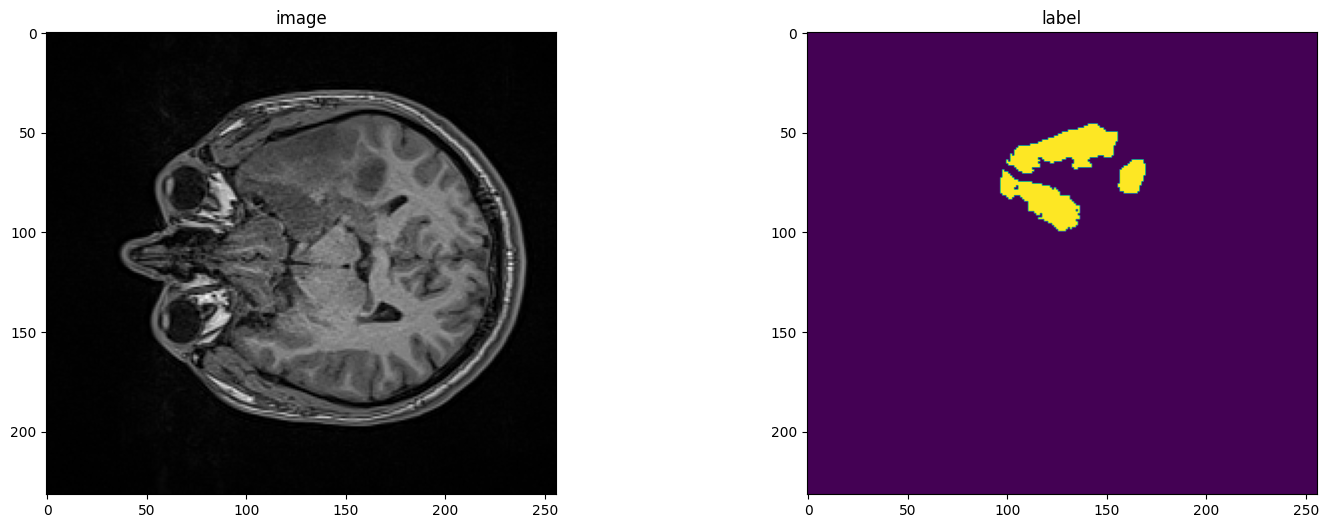

In [44]:
slice_num = 80

img = sample["img"][0][0]

label = (
    (sample["label"][0][0] == 1) * hyperparams.LABELS.BRAIN +
    (sample["label"][0][1] == 1) * hyperparams.LABELS.TUMOR
)

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.show()

In [45]:
logger.info("Starting test")

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:2521096804.py:<module>:1] Starting test


In [51]:
model = model.to(hyperparams.DEVICE)

In [53]:
model = model.eval()

In [55]:
model_inferer = partial(
    sliding_window_inference,
    roi_size=hyperparams.ROI,
    sw_batch_size=hyperparams.SW_BATCH_SIZE,
    predictor=model,
    overlap=hyperparams.INFER_OVERLAP,
)

In [56]:
dice_metric = DiceMetric(include_background=True, reduction="mean_batch")

In [57]:
test_accuracy = miscutils.AverageMeter()
test_loss = miscutils.AverageMeter()

In [69]:
post_softmax = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5, dtype="int8")

In [60]:
image = sample["img"]
label = sample["label"]

In [61]:
with torch.no_grad():
    logits = model_inferer(image)

/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [62]:
logits.shape

torch.Size([1, 2, 232, 256, 176])

In [64]:
post_softmax(logits).shape

torch.Size([1, 2, 232, 256, 176])

In [78]:
seg = post_pred(post_softmax(logits[0])).detach().cpu().numpy()

In [137]:
seg.dtype

dtype('int8')

In [227]:
def one_hot_to_discrete(
    target: Union[torch.Tensor, np.ndarray],
    labels: DotConfig[str, str]
)-> np.ndarray:
    """Transform tensor in the one hot form to the discrete form.

    Args:
        target: Tensor to transform. Expected shape is (L, H, W, D) where L is the
            number of labels.
        labels: Labels to use in transformation

    Returns:
        Discrete transformed array, with `int8` dtype.
    """
    L, H, W, D = target.shape
    target_discrete = np.ones((H, W, D), dtype=np.int8) * labels.GROUND
    
    target_discrete[target[0] == 1] = labels.BRAIN
    target_discrete[target[1] == 1] = labels.TUMOR
    
    return target_discrete

In [214]:
import numpy as np

In [215]:
del seg_out

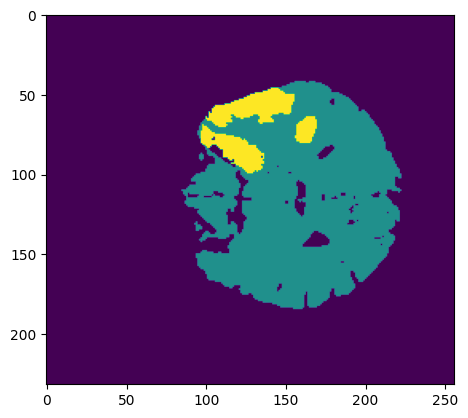

In [229]:
gt_label = sample["label"][0]

gt_out = one_hot_to_discrete(gt_label, hyperparams.LABELS)

plt.imshow(gt_out[:, :, slice_num])
plt.show()

In [231]:
seg.shape

(2, 232, 256, 176)

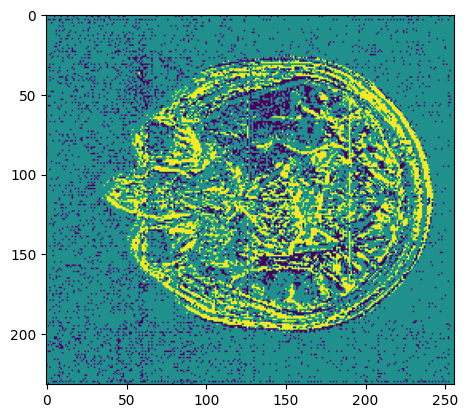

In [232]:
seg_out = one_hot_to_discrete(seg, hyperparams.LABELS)

plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [201]:
dice_loss(input=logits, target=label)

tensor(0.9875)

In [202]:
from bts.data.utils import save_prediction_as_nrrd

In [222]:
seg_t = torch.Tensor(seg_out).to(torch.int8)
gt_t = torch.Tensor(gt_out).to(torch.int8)

In [151]:
!mkdir infers

In [225]:
save_prediction_as_nrrd(
    prediction=seg_t,
    index_in_batch=0,
    file="infers/pred.nrrd",
    meta_dict=sample["img_meta_dict"],
)

In [226]:
save_prediction_as_nrrd(
    prediction=gt_t,
    index_in_batch=0,
    file="infers/target.nrrd",
    meta_dict=sample["img_meta_dict"],
)